# SECOM： SVM 
此 Notebook 用 **Support Vector Machine (SVM)**  做模型訓練/評估。
- 缺失值：`SimpleImputer(strategy='median')`
- 縮放：`StandardScaler`
- 分類器：`SVC(RBF, class_weight='balanced', probability=True)`
- 交叉驗證：`GridSearchCV`（以 ROC AUC 為主，並同時計算 F1/Recall/Precision/Accuracy）
- 輸出：分類報告、混淆矩陣、ROC 曲線；另存最佳模型 `svm_best.joblib`，圖檔存於 `outputs/`

## 1) 匯入與設定

In [19]:
# 若於新環境，取消下行註解安裝必要套件：
!pip install -q numpy pandas scikit-learn matplotlib joblib

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    f1_score, accuracy_score, precision_score, recall_score, roc_curve
)
from sklearn.metrics import make_scorer
from sklearn.utils.class_weight import compute_class_weight
from joblib import dump

# 輸出資料夾
# os.makedirs('plots-svm', exist_ok=True)
for folder in ['plots-svm', 'model-svm']:
    os.makedirs(folder, exist_ok=True)

## 2) 參數

In [20]:
# === 請修改成你的資料路徑與目標欄位 ===
DATA_PATH    = '../data/uci-secom.csv'   # 例：'data/secom.csv'
TARGET_COL   = 'Pass/Fail'   # 若不存在，會自動嘗試 'y'、'target'、'label'
TEST_SIZE    = 0.2
RANDOM_STATE = 42
# SAVE_MODEL   = 'svm_best.joblib'
# 設定檔案完整路徑（放在 output_model 資料夾下）
SAVE_MODEL = os.path.join("model-svm", "best_model.joblib")

## 3) 輔助函式

In [4]:
def infer_target(y: pd.Series) -> pd.Series:
    """統一標籤：回傳 1=Fail, 0=Pass。支援 -1/1、0/1 或字串。"""
    y = y.copy()
    u = set(pd.unique(y.dropna()))
    if u <= {-1, 1}:           # SECOM 常見：-1=Fail, 1=Pass
        return (y == -1).astype(int)
    if u <= {0, 1}:
        return y.astype(int)
    mapping = {'fail':1,'Fail':1,'FAIL':1,-1:1,
               'pass':0,'Pass':0,'PASS':0, 1:0, 0:0}
    return y.map(mapping).astype(int)

def load_data(path: str, target_col: str):
    df = pd.read_csv(path)
    if target_col not in df.columns:
        candidates = [c for c in ['Pass/Fail', 'y', 'target', 'label'] if c in df.columns]
        if not candidates:
            raise ValueError(f"找不到目標欄位：{target_col}，且也無常見欄位（Pass/Fail, y, target, label）。")
        target_col = candidates[0]
        print(f"[Info] 未找到指定目標欄位，改用自動偵測：{target_col}")
    y = infer_target(df[target_col])
    X = df.drop(columns=[target_col])
    num_cols = X.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        raise ValueError('資料沒有數值型特徵可用。請檢查輸入資料。')
    X = X[num_cols]
    return X, y, num_cols

## 4) 讀取資料與切分

In [5]:
X, y, used_cols = load_data(DATA_PATH, TARGET_COL)
print(f"[Info] X shape = {X.shape}, 目標 1 比例(=Fail) = {y.mean():.3f}")
print(f"[Info] 使用的數值特徵數：{len(used_cols)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

classes = np.array([0,1])
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
print(f"[Info] 訓練集 class_weight 建議：{{0: {cw[0]:.3f}, 1: {cw[1]:.3f}}}")

[Info] X shape = (1567, 590), 目標 1 比例(=Fail) = 0.934
[Info] 使用的數值特徵數：590
[Info] 訓練集 class_weight 建議：{0: 7.548, 1: 0.535}


## 5) 建立 SVM Pipeline 與參數搜尋（不含 PCA，直接改用 SVM）

In [7]:
# Pipeline：中位數填補 → 標準化 → SVM(RBF)
pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=RANDOM_STATE))
])

param_grid = {
    'svm__C': [0.5, 1, 2, 4, 8],
    'svm__gamma': ['scale', 0.01, 0.001]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    'roc_auc': 'roc_auc',
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

## 6) 訓練與最佳化

In [8]:
grid.fit(X_train, y_train)
print('\n===== 交叉驗證最佳參數 =====')
print(grid.best_params_)
print(f"CV best ROC_AUC: {grid.best_score_:.4f}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits

===== 交叉驗證最佳參數 =====
{'svm__C': 4, 'svm__gamma': 0.01}
CV best ROC_AUC: 0.6875


## 7) 測試集評估

In [9]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print('\n===== 測試集結果 =====')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification report (1 = Fail):')
print(classification_report(y_test, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1: {f1_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")


===== 測試集結果 =====
Confusion matrix:
[[  0  21]
 [  0 293]]

Classification report (1 = Fail):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        21
           1     0.9331    1.0000    0.9654       293

    accuracy                         0.9331       314
   macro avg     0.4666    0.5000    0.4827       314
weighted avg     0.8707    0.9331    0.9008       314

ROC AUC: 0.6164
Accuracy: 0.9331
F1: 0.9654
Recall: 1.0000
Precision: 0.9331


## 8) 視覺化：混淆矩陣熱圖 & ROC 曲線

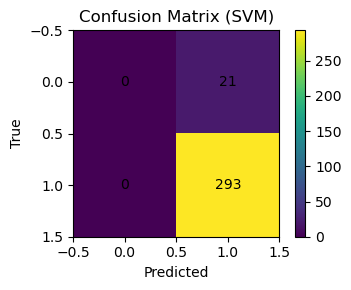

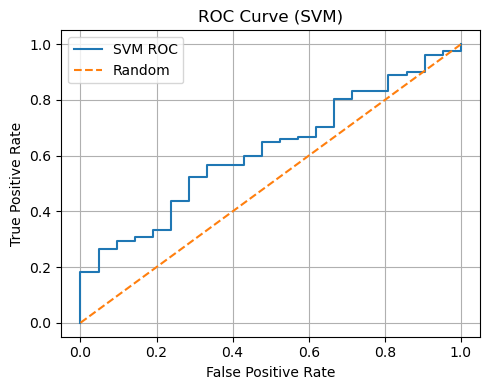

In [21]:
# 混淆矩陣熱圖（使用 matplotlib）
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (SVM)')
plt.xlabel('Predicted')
plt.ylabel('True')
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.colorbar()
plt.tight_layout()
plt.savefig('plots-svm/confusion_matrix_svm.png', dpi=140)
plt.show()

# ROC 曲線
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='SVM ROC')
plt.plot([0,1],[0,1],'--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SVM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('plots-svm/roc_curve_svm.png', dpi=140)
plt.show()

## 9) 儲存最佳模型

In [22]:
dump(best_model, SAVE_MODEL)
print(f"[Info] 已儲存最佳模型至：{SAVE_MODEL}")

[Info] 已儲存最佳模型至：model-svm\best_model.joblib
